In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR

# импортирую свои модули
import os
import sys
sys.path.append(os.path.abspath('..'))
from figures.plots import show_embeddings
from src.models import RepeatAutoencoder, BidirectionalAutoencoder
from src.loss import BidirectionalMSELoss
from data.dataloading import load_dataset, SequenceLengthSampler, pad_collate

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = load_dataset()

train_len = int(0.8 * len(dataset))
test_len = len(dataset) - train_len
train_dataset, test_dataset = random_split(dataset, lengths=[train_len, test_len])

bucket_boundaries = [2, 4, 6, 7, 10, 15, 20, 30, 40, 60, 80, 100]
lengths = [(i, len(item)) for i, item in enumerate(train_dataset)]
sampler = SequenceLengthSampler(lengths, bucket_boundaries, batch_size=16)

dataloader = DataLoader(train_dataset, collate_fn=pad_collate, batch_sampler=sampler)

In [3]:
model = RepeatAutoencoder(3, 16, 3)

In [4]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.8)

In [5]:
def validate(model, val_data, criterion):
    model.eval()
    loss_history = []
    for i, x in enumerate(val_data):
        x = x.unsqueeze(0)
        output = model(x)
        loss = criterion(output, x).item()
        loss_history.append(loss)
    return np.mean(loss_history)

In [6]:
train_history = []
val_history = []

for epoch in range(50):
    accumulated_loss = []
    for i, x in enumerate(dataloader):
        model.train()
        output = model(x)
        loss = criterion(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        accumulated_loss.append(loss.item())
    
    train_loss = np.mean(accumulated_loss)
    val_loss = validate(model, test_dataset, criterion)
    
    # if val_loss < val_history[-1]:
    #     torch.save(model.state_dict(), '../src/weights/pa.pth')
    
    train_history.append(train_loss)
    val_history.append(val_loss)
    
    print(f'Train loss: {train_loss}, Val loss: {val_loss}, epoch: {epoch}')
    
    scheduler.step()

Train loss: 2.01001632302821, Val loss: 1.7053653047889819, epoch: 0
Train loss: 1.0371727206392916, Val loss: 1.1191341621609834, epoch: 1
Train loss: 0.7241975337177694, Val loss: 0.9128245435717567, epoch: 2
Train loss: 0.5959613307596681, Val loss: 0.8008997764342679, epoch: 3
Train loss: 0.523406831112629, Val loss: 0.7316196111076526, epoch: 4
Train loss: 0.48063420997319106, Val loss: 0.6874450297960699, epoch: 5
Train loss: 0.45283677449037213, Val loss: 0.658657492881781, epoch: 6
Train loss: 0.4345966709588102, Val loss: 0.619714857470251, epoch: 7
Train loss: 0.41404088114773085, Val loss: 0.5981618029132632, epoch: 8
Train loss: 0.3939852418076849, Val loss: 0.5671075015812813, epoch: 9
Train loss: 0.3800010344649325, Val loss: 0.5475185024016639, epoch: 10
Train loss: 0.3635755737875393, Val loss: 0.5301578673293119, epoch: 11
Train loss: 0.3551099638114432, Val loss: 0.5142288777634686, epoch: 12
Train loss: 0.3432654722643916, Val loss: 0.5027903647408257, epoch: 13
Trai

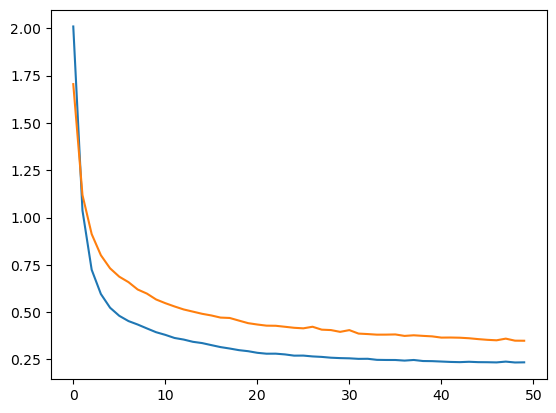

In [7]:
plt.plot(train_history)
plt.plot(val_history)

In [29]:
# torch.save(model.state_dict(), '../src/weights/pa.pth')

In [14]:
x = test_dataset[16].unsqueeze(0)
output = model(x)

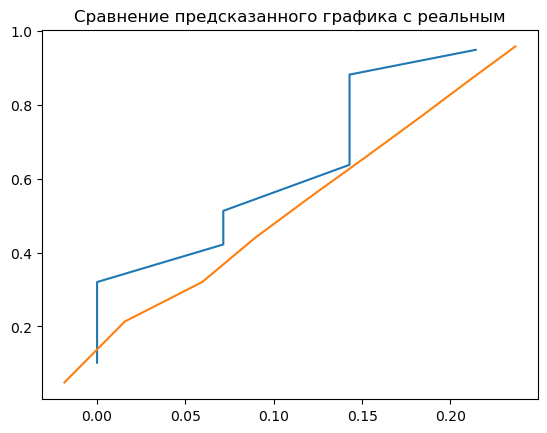

In [15]:
plt.title('Сравнение предсказанного графика с реальным')
i = 0
plt.plot(x[i, :, 0], x[i, :, 1])
plt.plot(output[i, :, 0].detach(), output[i, :, 1].detach())
# plt.savefig('../figures/supplier_spec_history.jpg', bbox_inches='tight')

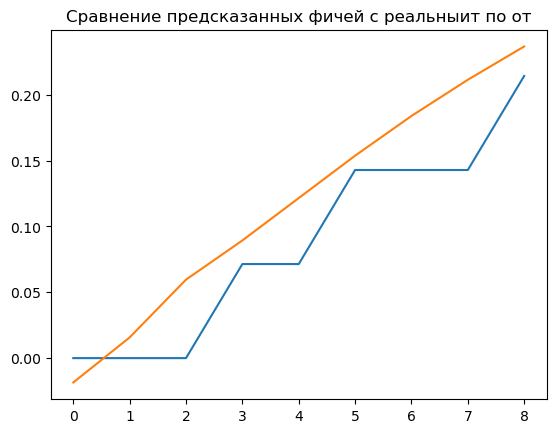

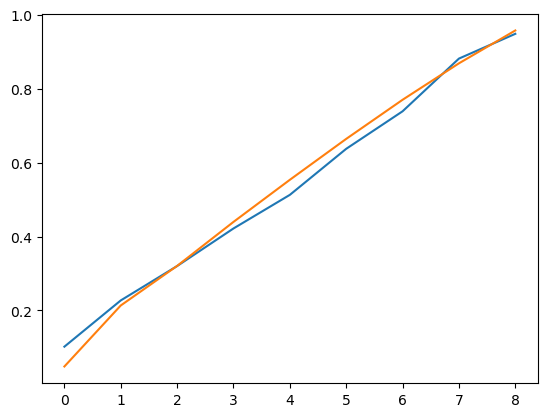

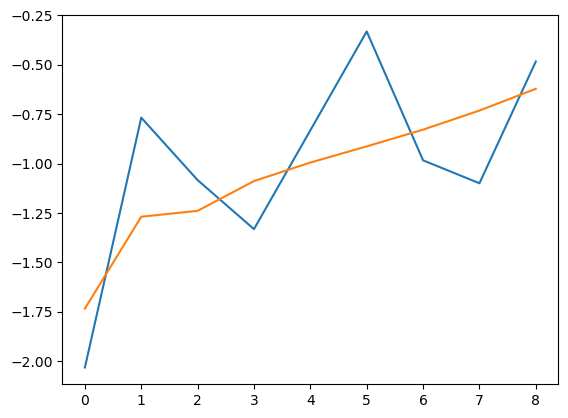

In [16]:
plt.title('Сравнение предсказанных фичей с реальныит по от')
i = 0
for feature in range(3):
    plt.plot(x[i, :, feature])
    plt.plot(output[i, :, feature].detach())
    plt.show()

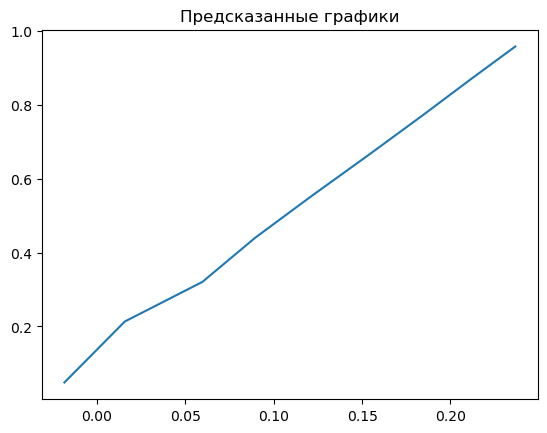

In [21]:
plt.title('Предсказанные графики')
for i in range(output.shape[0]):
    plt.plot(output[i, :, 0].detach(), output[i, :, 1].detach())

In [22]:
supplier_set = set(dataset.supplier[30:45])

indexes = np.where([
    (supplier in supplier_set) for supplier in dataset.supplier
])[0]

In [33]:
seqs = [dataset[i] for i in indexes]
suppliers = [dataset.supplier[i] for i in indexes]
embs = np.stack([model.encoder(seq.unsqueeze(0))[1][0].squeeze().detach().numpy() for seq in seqs])

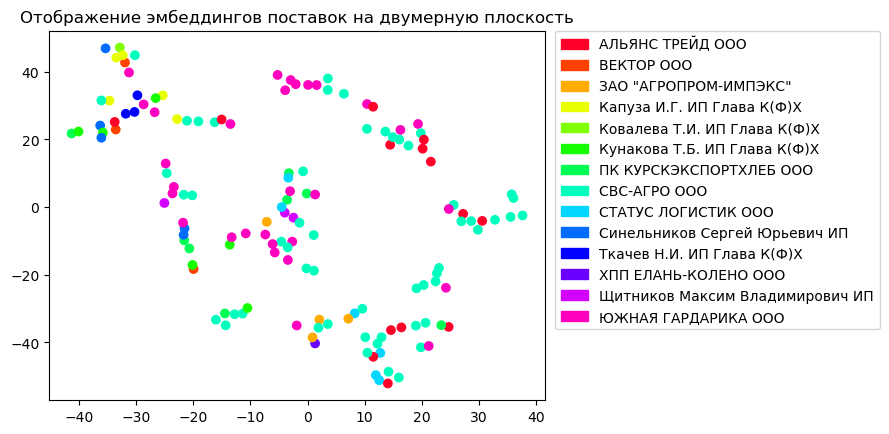

In [34]:
plt.title('Отображение эмбеддингов поставок на двумерную плоскость')
show_embeddings(embs, suppliers)
# plt.savefig('../figures/tsne_spec_embedings.jpg', bbox_inches='tight')

In [47]:
"""
Собираем датасет с эмбеддингами поставок
"""

embed_df = pd.DataFrame(columns = ['id', 'supplier', 'date'] +
                        [f'{i}' for i in range(model.hidden_dim)])
for i, x in tqdm(enumerate(dataset)):
    embed = model.encoder(x.unsqueeze(0))[1][0]
    
    embed = embed[0, -1].detach().tolist()
    spec_data = [dataset.specs[i], dataset.supplier[i], dataset.specs_date[i]]
    
    embed_df.loc[len(embed_df)] = spec_data + embed

3428it [00:17, 190.91it/s]


In [48]:
embed_df.to_csv('../data/processed_data/embed_df.csv', index=False)

In [49]:
embed_df.head(2)

,id,supplier,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Рязанова А.В. ИП Глава К(Ф)Х_ЮР Валуйский МЭЗ ...,Рязанова А.В. ИП Глава К(Ф)Х,2022-07-09,-0.134818,-0.134237,0.205977,-0.203913,0.445985,-0.021814,-0.18290,0.179079,-0.346074,0.266316,-0.274305,-0.275367,0.106079,-0.030919,0.149763,0.429762
1,"Осипов Л.А. ИП Глава К(Ф)Х_Юг Руси, АО_2022-07-12",Осипов Л.А. ИП Глава К(Ф)Х,2022-07-22,-0.432994,-0.454678,0.078256,-0.487130,0.649082,0.216361,-0.90893,0.188233,-0.906585,0.818795,-0.790245,-0.229075,0.758675,-0.435782,0.540058,0.806282
